In [3]:
import numpy as np
import xarray as xr
import pandas as pd
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Activation, MaxPool2D
from tensorflow.keras.models import Model, save_model
import matplotlib.pyplot as plt
import FourierOpticsLib as FO
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
ds_path = "/scr/sci/mhayman/holodec/holodec-ml-data/"
# ds_path = "../../"
ds = xr.open_dataset(ds_path+"synthethic_holograms_v0.nc")

In [4]:
split_index = 7000
all_labels = ds[["x", "y", "z", "d"]].to_dataframe()
train_labels = all_labels.iloc[:split_index]
test_labels = all_labels.iloc[split_index:]
scaler = MinMaxScaler()
scaled_train_labels = pd.DataFrame(scaler.fit_transform(train_labels), index=train_labels.index, columns=train_labels.columns)
scaled_test_labels = pd.DataFrame(scaler.transform(test_labels), index=test_labels.index, columns=test_labels.columns)

In [5]:
in_data = ds["image"].transpose("hologram_number", "ysize", 'xsize').expand_dims("channel", 3)

In [8]:
ds["image"].dims

('ysize', 'xsize', 'hologram_number')

In [6]:
scaled_in_data = in_data.astype(np.float16) / 255

In [11]:
conv_input = Input(shape=(400, 600, 1))
conv_1 = Conv2D(8, (5, 5), padding="same")(conv_input)
act_1 = Activation("relu")(conv_1)
pool_1 = MaxPool2D(pool_size=(4, 4))(act_1)
conv_2 = Conv2D(16, (5, 5), padding="same")(pool_1)
act_2 = Activation("relu")(conv_2)
pool_2 = MaxPool2D(pool_size=(4, 4))(act_2)
conv_3 = Conv2D(32, (5, 5), padding="same")(pool_2)
act_3 = Activation("relu")(conv_3)
pool_3 = MaxPool2D(pool_size=(4, 4))(act_3)
flat = Flatten()(pool_3)
dense_1 = Dense(64, activation="relu")(flat)
dense_2 = Dense(32, activation="relu")(dense_1)
out = Dense(4)(dense_2)
mod = Model(conv_input, out)
mod.compile(optimizer="adam", loss="mae")
mod.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 400, 600, 1)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 400, 600, 8)       208       
_________________________________________________________________
activation (Activation)      (None, 400, 600, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 150, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 150, 16)      3216      
_________________________________________________________________
activation_1 (Activation)    (None, 100, 150, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 37, 16)        0     

In [29]:
mod.fit(scaled_in_data[:split_index].values, scaled_train_labels.values, batch_size=16, epochs=30, verbose=1)

Train on 7000 samples
Epoch 1/30
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0256
Epoch 2/30
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0247
Epoch 3/30
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0247
Epoch 4/30
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0248
Epoch 5/30
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0232
Epoch 6/30
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0228
Epoch 7/30
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0233
Epoch 8/30
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0228
Epoch 9/30
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0219
Epoch 10/30
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0215
Epoch 11/30
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0217
Epoch 12/30
7000/7000 [=======

In [30]:
preds_out = mod.predict(scaled_in_data.values, batch_size=64)

In [109]:
save_model(mod, "holodec_cnn.h5", save_format="h5")

In [31]:
preds_original = scaler.inverse_transform(preds_out)

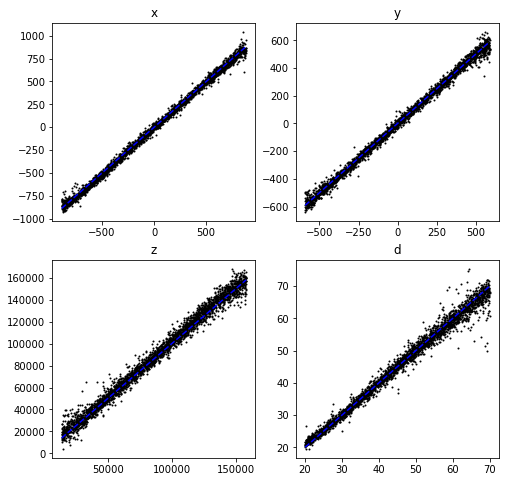

In [89]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for a, ax in enumerate(axes.ravel()):
    ax.scatter(test_labels.iloc[:, a], preds_original[split_index:, a], 1, 'k')
    diag = np.linspace(test_labels.iloc[:, a].min(), test_labels.iloc[:, a].max(), 10)
    ax.plot(diag, diag, 'b--' )
    ax.set_title(test_labels.columns[a])
plt.savefig("error_hist.png", dpi=200, bbox_inches="tight")

In [33]:
np.mean(np.abs(preds_original[split_index:] - test_labels.values), axis=0)

array([2.1903341e+01, 1.7490278e+01, 3.9802427e+03, 1.1206932e+00],
      dtype=float32)

In [34]:
np.mean(np.abs(preds_out[split_index:] - scaled_test_labels.values), axis=0)

array([0.01235707, 0.01481148, 0.02764406, 0.02242596])

In [81]:
scaled_test_labels.iloc[index, 0:2]

x    0.945862
y    0.435532
Name: 9343, dtype: float64

In [92]:
preds_out.shape

(10000, 4)

In [ ]:
scaled

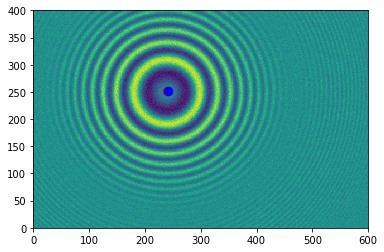

In [107]:
index = 216
plt.pcolormesh(scaled_in_data[split_index + index, :, :, 0])
plt.scatter(scaled_test_labels.iloc[index, 0] * 600, scaled_test_labels.iloc[index, 1] * 400, 2 * test_labels.iloc[index, -1], 'r')
plt.scatter(preds_out[split_index + index, 0] * 600, preds_out[split_index + index, 1] * 400, 2 * preds_original[split_index + index, -1], 'b')

In [40]:
preds_original[]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [99]:
test_labels["d"].max()

69.97508

In [48]:
ds["xsize"]

<xarray.DataArray 'xsize' (xsize: 600)>
array([  0,   1,   2, ..., 597, 598, 599])
Dimensions without coordinates: xsize

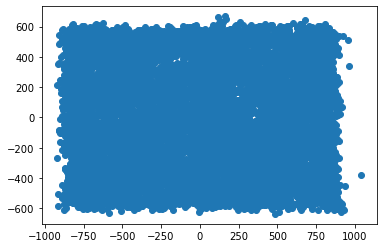

In [49]:
plt.scatter(preds_original[:, 0], preds_original[:, 1])